In [17]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau
import datetime
import tqdm

In [18]:
df = pd.read_csv('/Users/giovanni-lunetta/uconn_masters/stat5405/final_project/nfl-big-data-bowl-2020/train.csv')

/var/folders/4b/z0w6x5_n59g_x_9s3qnbx_p80000gn/T/ipykernel_6813/3537902994.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/giovanni-lunetta/uconn_masters/stat5405/final_project/nfl-big-data-bowl-2020/train.csv')


In [19]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW


In [20]:
print(df.shape)
print(df.columns)
print(df.dtypes)

(682154, 49)
Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
GameId                      int64
PlayId                      int64
Team                       object
X                         float64
Y                         float64
S                         float64
A                         flo

In [21]:
def windspeed(x):
    x=str(x)
    if x.isdigit():
        return int(x)
    elif (x.isalpha()):
        return 0
    elif (x.isalnum()):
        return int(x.upper().split('M')[0])                             #return 12 incase of 12mp or 12 MPH
    elif '-' in x:
        return int((int(x.split('-')[0])+int(x.split('-')[1]))/2)   # return average windspeed incase of 11 - 20 etc..
    else:
        return 0

In [22]:
# Let's just apply our fix to the messed up values 
df['WindSpeed']=df['WindSpeed'].apply(windspeed)
# Then, lets just fill the missing values with the average, as we have been doing 
df['WindSpeed'].fillna(df['WindSpeed'].mean(),inplace=True)

/var/folders/4b/z0w6x5_n59g_x_9s3qnbx_p80000gn/T/ipykernel_6813/96105120.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['WindSpeed'])


<Axes: xlabel='WindSpeed', ylabel='Density'>

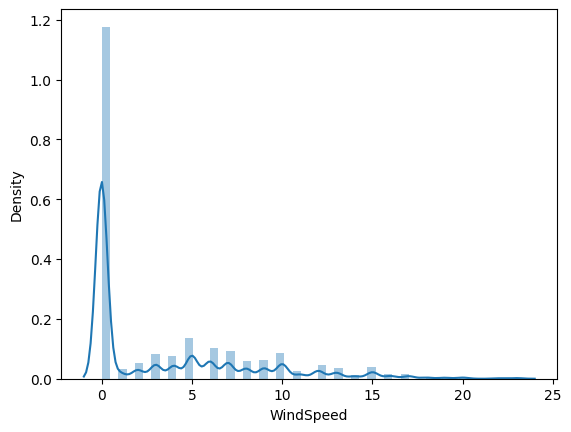

In [23]:
sns.distplot(df['WindSpeed'])

In [24]:
# So wind direction is a bit confusing in that it is all base on WHERE it comes from
# We can see that it has the same problem as wind speed: multiple wants for saying the same thing.
# So we need to handle these cases indv
# We are going to reduce the number of options a bit 

def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM N' in wd:
        return 'north'
    if wd == 'S' or 'FROM S' in wd:
        return 'south'
    if wd == 'W' or 'FROM W' in wd:
        return 'west'
    if wd == 'E' or 'FROM E' in wd:
        return 'east'
    
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'south west'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'south east'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'north west'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'north east'
    
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'none'

df['WindDirection'] = df['WindDirection'].apply(clean_wind_direction)

In [25]:
df['Humidity'].fillna(method='ffill', inplace=True)
df['Temperature'].fillna(method='ffill', inplace=True)

In [26]:
na_map = {
    # What is the average orientation of the playrees
    'Orientation': df['Orientation'].mean(),
    # Average direction 
    'Dir': df['Dir'].mean(),
    # Average # of defenders in the box (# of defenders directly opposing person with the ball)
    'DefendersInTheBox': np.math.ceil(df['DefendersInTheBox'].mean()),
    # What formation the team is using is really important, but often some teams use custom formations
    # In the case we will just say that we don't know
    'OffenseFormation': 'UNKNOWN'
}

df.fillna(na_map, inplace=True)

In [27]:
def group_game_weather(weather):
    rain = [
        'Rainy', 'Rain Chance 40%', 'Showers',
        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain'
    ]
    overcast = [
        'Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
        'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
        'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
        'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
        'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
        'Partly Cloudy', 'Cloudy'
    ]
    clear = [
        'Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
        'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
        'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
        'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
        'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
        'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny'
    ]
    snow  = ['Heavy lake effect snow', 'Snow']
    none  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 'rain'
    elif weather in overcast:
        return 'overcast'
    elif weather in clear:
        return 'clear'
    elif weather in snow:
        return 'snow'
    elif weather in none:
        return 'none'
    
    return 'none'

df['GameWeather'] = df['GameWeather'].apply(group_game_weather)

df['FieldPosition'] = np.where(df['YardLine'] == 50, df['PossessionTeam'], df['FieldPosition'])

In [28]:
def group_stadium_types(stadium):
    outdoor       = [
        'Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
        'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
        'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl'
    ]
    indoor_closed = [
        'Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
        'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',
    ]
    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 'outdoor'
    elif stadium in indoor_closed:
        return 'indoor closed'
    elif stadium in indoor_open:
        return 'indoor open'
    elif stadium in dome_closed:
        return 'dome closed'
    elif stadium in dome_open:
        return 'dome open'
    else:
        return 'unknown'
    
df['StadiumType'] = df['StadiumType'].apply(group_stadium_types)